In [ ]:
# !pip uninstall -y numpy
# !pip install numpy==1.26.4

In [ ]:
# !pip install tbats
# !pip install prophet
# !pip install pmdarima  # not work with numpy greater or equal than 2

In [ ]:
# import os
# os.kill(os.getpid(), 9)

# Import dependencies

In [ ]:
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tbats import BATS, TBATS
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_absolute_percentage_error, root_mean_squared_error)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [ ]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
print("Path to dataset files:", path)

100%|██████████| 11.4M/11.4M [00:00<00:00, 103MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


In [ ]:
df = pd.read_csv(path + '/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


This data have following columns:
* Datetime: hourly datetime over all dataset
* PJMW_MW: estimated energy consumption in Megawatts (MW) over datetime

# Data preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')
# df.set_index('Datetime', inplace=True)

# as mentioned before, we have hourly energy consumption data in Megawatts (MW)
# this means that our datetime entries should have a one-hour difference between consecutive data points

# but firstly lets check that we have sorted datetime
df = df.sort_values(by='Datetime')
df.reset_index(drop=True, inplace=True)

df['diff'] = df['Datetime'].diff()
df['diff'].value_counts()

,count
diff,
0 days 01:00:00,143171
0 days 02:00:00,30
0 days 00:00:00,4


In [ ]:
# we observe that on the one hand, we have missing values because we have more
# than one-hour difference between consecutive data points
# and on the other hand, we have duplicates

num_of_duplicates = df.duplicated(subset='Datetime').sum()
print(f'Count of duplicates datetime in df: {num_of_duplicates}')

df.drop_duplicates(subset='Datetime', inplace=True)

Count of duplicates datetime in df: 4


In [ ]:
df.set_index('Datetime', inplace=True)
df = df.resample('h').asfreq().interpolate()
df.drop(columns='diff', inplace=True)

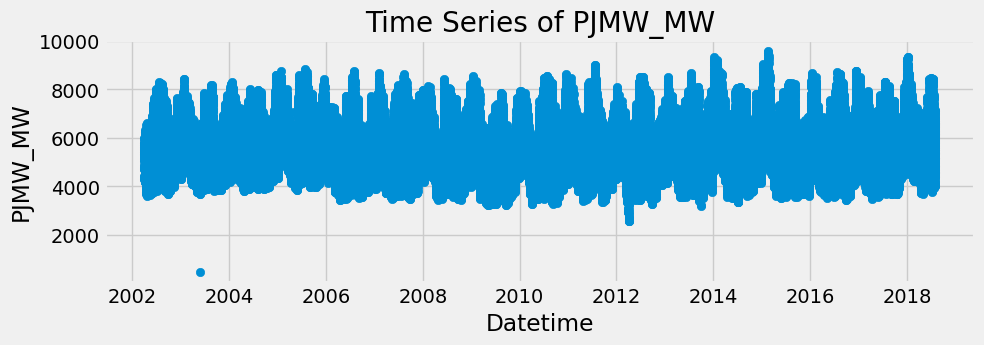

In [ ]:
# let's take a look at data
plt.figure(figsize=(10, 3))
plt.scatter(df.index, df['PJMW_MW'])
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.title('Time Series of PJMW_MW')
plt.show()

Outliers are clearly observable in the data and can badly affect further modeling, so adressing them early is important.

# Handling with outliers in time series data

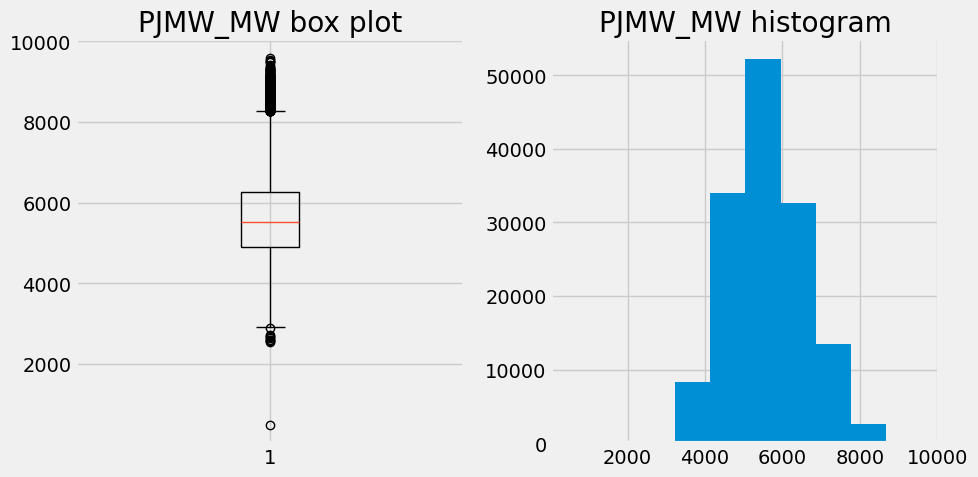

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].boxplot(df['PJMW_MW'])
ax[0].set_title('PJMW_MW box plot')

ax[1].hist(df['PJMW_MW'])
ax[1].set_title('PJMW_MW histogram')

plt.tight_layout()
plt.show()

In time series data we can get point outlier, subsequence outlier or something named like contextual outlier. In this case we have point outlier and potential subsequence outlier as well. To detect these outliers, we can use simple visual analysis, STL decomposition analysis, or statistical methods like Z-score or IQR. More complex approaches include Isolation Forest, Local Outlier Factor (LOF), anomaly detection using forecasting models (like Prophet), clustering-based anomaly detection, or autoencoders.

## Statistical IQR

In [ ]:
def remove_outliers(dataframe, column, iqr_multiplier=1.5):
  q1 = dataframe[column].quantile(0.25)
  q3 = dataframe[column].quantile(0.75)
  iqr = q3-q1

  upper_limit = q3 + (iqr_multiplier*iqr)
  lower_limit = q1 - (iqr_multiplier*iqr)
  return upper_limit, lower_limit

In [ ]:
remove_outliers(df, 'PJMW_MW')

(8271.0, 2887.0)

See that this approach delete nearly all data which not in boxplot boundiries.

## Isolation Forest

In [ ]:
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
IsolationForest(contamination=0.01)

IsolationForest(contamination=0.01)

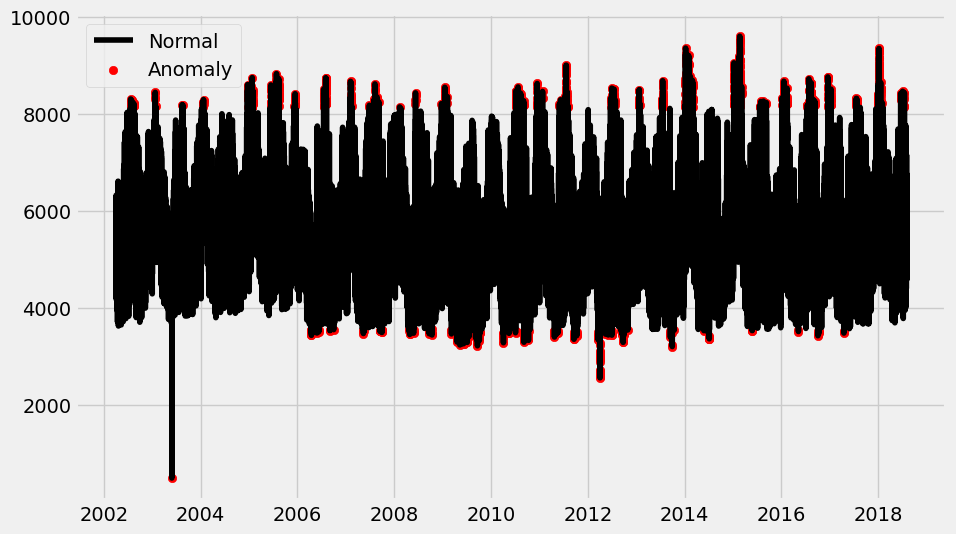

In [ ]:
df_if = df.copy()
df_if['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df_if.loc[df_if['anomaly'] == -1, ['PJMW_MW']]

ax.plot(df_if.index, df_if['PJMW_MW'], color='black', label = 'Normal')
ax.scatter(a.index,a['PJMW_MW'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

We see another result where anomaly detection flags data points as both significantly high spikes and significantly low spikes.

Ok then, in that case, I will focus solely on removing lower outliers using the lower limit calculated by the IQR method. I will leave the high outliers as they could represent normal values within the data's specific characteristics. But of course dealing with outliers is pretty fine work.

In [ ]:
df['PJMW_MW'] = np.where(df['PJMW_MW'] < 2887.0, np.nan, df['PJMW_MW'])

In [ ]:
# use next valid observation to fill the gap
df['PJMW_MW'] = df['PJMW_MW'].bfill()

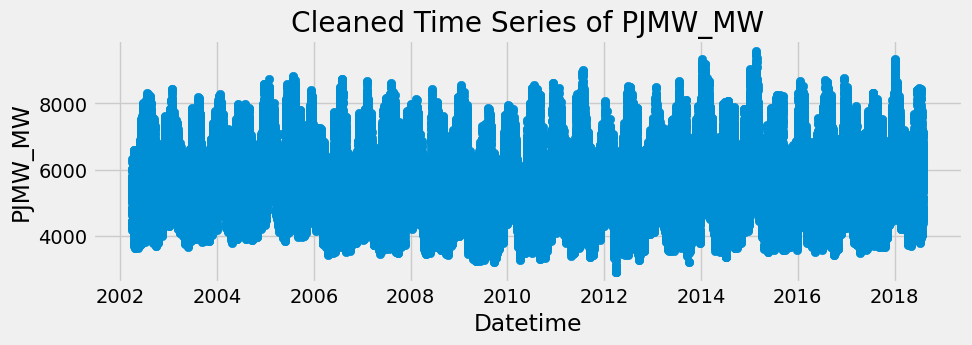

In [ ]:
# final data after all manipulation
plt.figure(figsize=(10, 3))
plt.scatter(df.index, df['PJMW_MW'])
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.title('Cleaned Time Series of PJMW_MW')
plt.show()

It is observable that our data exhibits seasonal fluctuations, which are important considerations for subsequent modeling using traditional time series techniques.

In [ ]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_name()
    df['n_dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Some EDA

Before each modeling section we extremely should make EDA for better data understanding. I mean that is really crucial moment and u will see it soon.

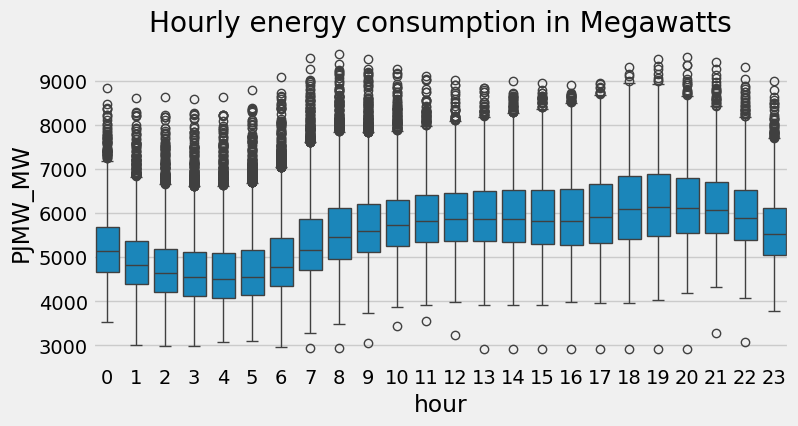

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='hour', y='PJMW_MW')
plt.title('Hourly energy consumption in Megawatts')

plt.show()

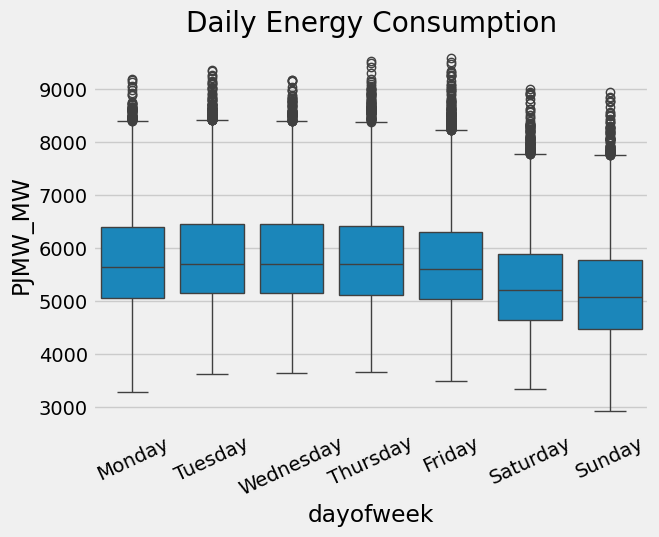

In [ ]:
sns.boxplot(data=df, x='dayofweek', y='PJMW_MW')
plt.title('Daily Energy Consumption')
plt.xticks(rotation=25)

plt.show()

The following data insights reveal a distinct hourly pattern and a less pronounced daily pattern. While energy consumption appears slightly lower on Saturdays and Sundays compared to weekdays, this difference is not such a significant, but it exist.

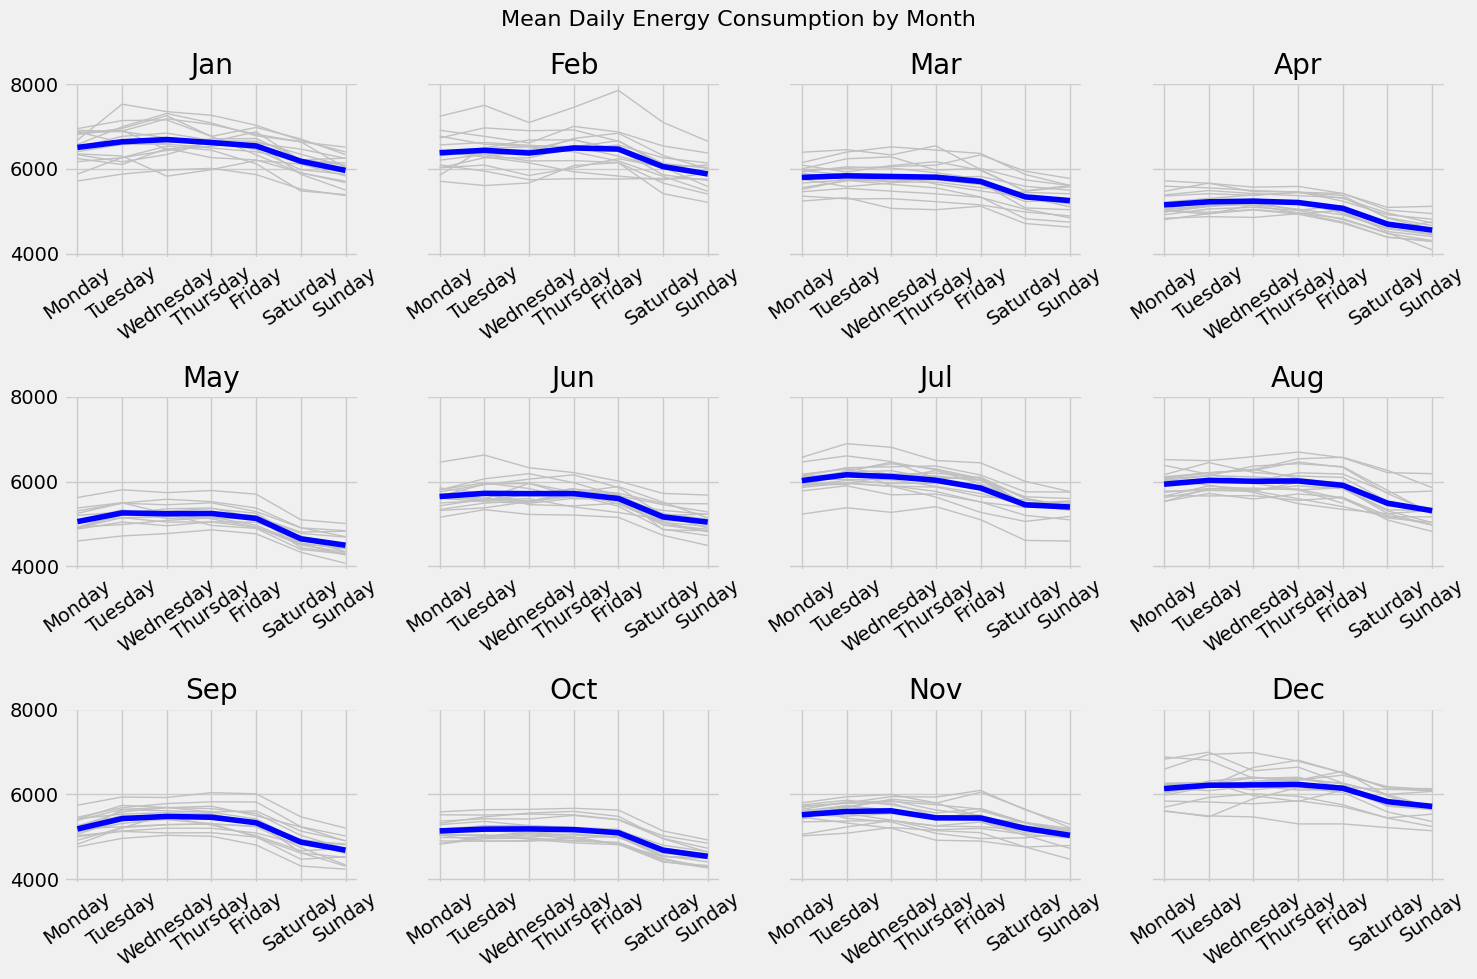

In [ ]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_dictionary = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
temp_table_dw = df.groupby(['year', 'month','dayofweek'])['PJMW_MW'].mean().reset_index()
temp_table_dw['dayofweek'] = pd.Categorical(temp_table_dw['dayofweek'], categories=weekday_order, ordered=True)
months = sorted(temp_table_dw['month'].unique())

fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for idx, month in enumerate(months):
    temp_df = temp_table_dw[temp_table_dw['month'] == month]
    ax = axes[idx]

    for year, group in temp_df.groupby('year'):
        sns.lineplot(data=group,
                     x='dayofweek',
                     y='PJMW_MW',
                     color='silver',
                     linewidth=1, ax=ax)

    monthly_mean = temp_df.groupby('dayofweek', observed=False)['PJMW_MW'].mean().reset_index()
    sns.lineplot(data=monthly_mean,
                 x='dayofweek',
                 y='PJMW_MW',
                 label='Mean',
                 color='blue',
                 ax=ax,
                 legend=False)

    ax.set_title(f"{month_dictionary[month]}")
    ax.tick_params(axis='x', rotation=35)
    ax.set_xlabel("")
    ax.set_ylabel("")

for i in range(len(months), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Mean Daily Energy Consumption by Month', fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.show()

We observe a decrease in mean energy consumption on weekends and a sharp increase on the first weekday of some months. However, this sharp increase isn't consistent across all months, with some months showing a smoother change in the mean.

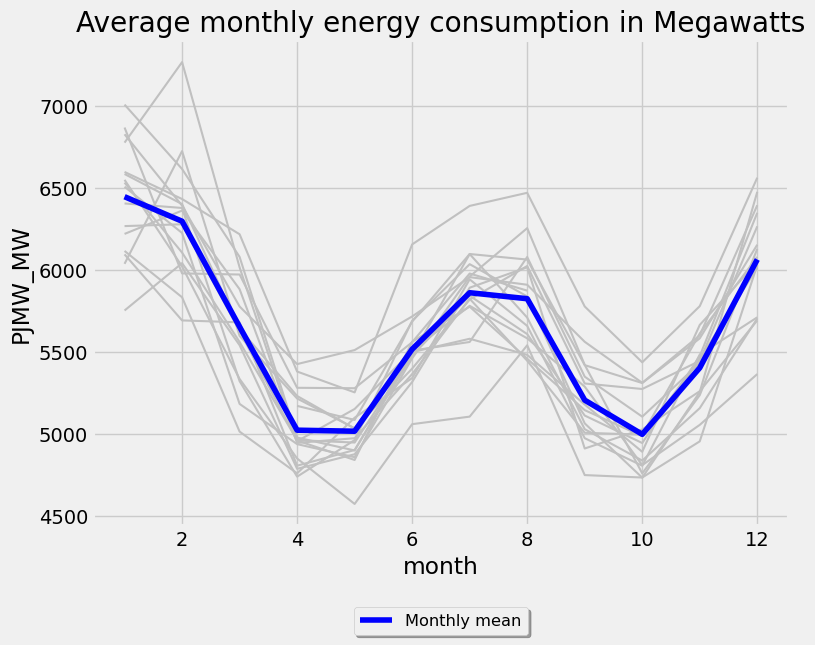

In [ ]:
temp_table_m = df.groupby(['year', 'month'])['PJMW_MW'].mean().reset_index()

plt.figure(figsize=(8, 6))
for year, group in temp_table_m.groupby('year'):
    sns.lineplot(data=group, x='month', y='PJMW_MW', color='silver', linewidth=1.5)

monthly_mean = temp_table_m.groupby('month')['PJMW_MW'].mean().reset_index()
sns.lineplot(data=monthly_mean, x='month', y='PJMW_MW', label='Monthly mean', color='blue')

plt.title('Average monthly energy consumption in Megawatts')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.show()

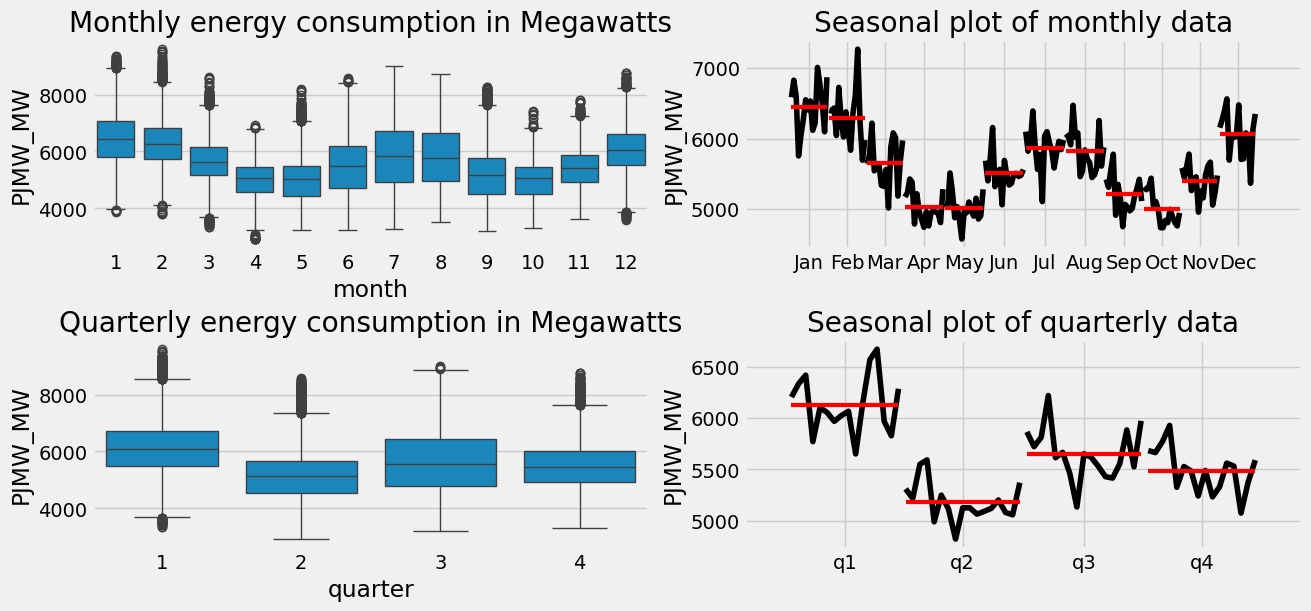

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(13, 6), constrained_layout=True)
sns.boxplot(data=df, x='month', y='PJMW_MW', ax=ax[0, 0])
ax[0, 0].set_title('Monthly energy consumption in Megawatts')

month_plot(df['PJMW_MW'].resample('ME').mean(), ylabel='PJMW_MW', ax=ax[0, 1])
ax[0, 1].set_title('Seasonal plot of monthly data')

sns.boxplot(data=df, x='quarter', y='PJMW_MW', ax=ax[1, 0])
ax[1, 0].set_title('Quarterly energy consumption in Megawatts')

quarter_plot(df['PJMW_MW'].resample('QE').mean(), ylabel='PJMW_MW', ax=ax[1, 1])
ax[1, 1].set_title('Seasonal plot of quarterly data')

# plt.tight_layout()
plt.show()

The plots above reveal a strong monthly seasonality and a reasonably valid quarterly seasonality.

So, to briefly summarize our EDA, we've observed several layers of seasonality in this data: hourly, daily to some extent, monthly, and even quarterly. While this richness of information is beneficial for feature extraction, it also presents challenges for applying classical time series models like ARIMA or ETS universally. Creating a single, robust model capable of accurate long-term forecasts (e.g., several months or quarters) and short-term forecasts (e.g., several hours) across all possible scenarios appears difficult for that kind of models, but not impossible. Therefore, we should tailor our model selection and configuration to the specific forecasting task at hand to implement classic model or try to build more complex models like XGBoost or Prophet.

## Stationarity checking and ACF/PACF for all data

Let's see what I mean about my text above:

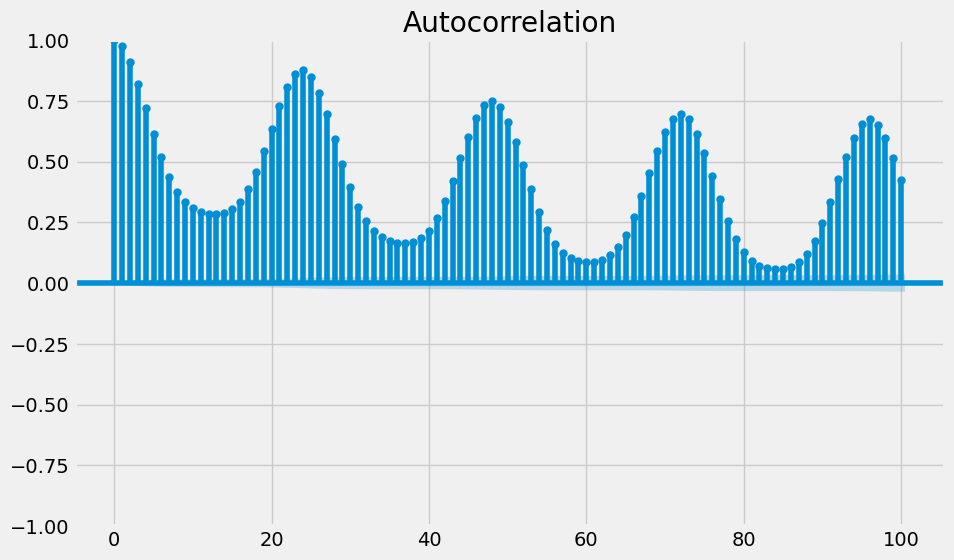

In [ ]:
fig = plot_acf(df['PJMW_MW'], lags=100)  # method = "ols" or "ywmle"
fig.set_size_inches(10, 6)
plt.show()

The ACF plot reveals a significant spike at a lag of 24, indicating strong hourly seasonality. Additionally, we observe a persistent and substantial autocorrelation extending beyond 100 lags, suggesting the presence of further underlying seasonality.

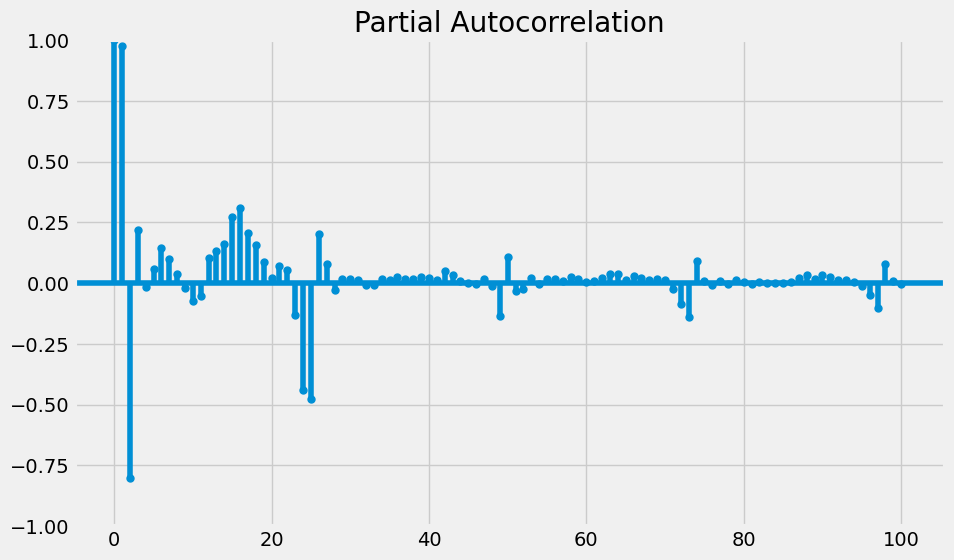

In [ ]:
fig = plot_pacf(df['PJMW_MW'], lags=100)
fig.set_size_inches(10, 6)
plt.show()

In [ ]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(df['PJMW_MW'])

ADF Statistic: -19.935562
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


## Seasonal decomposition for all data

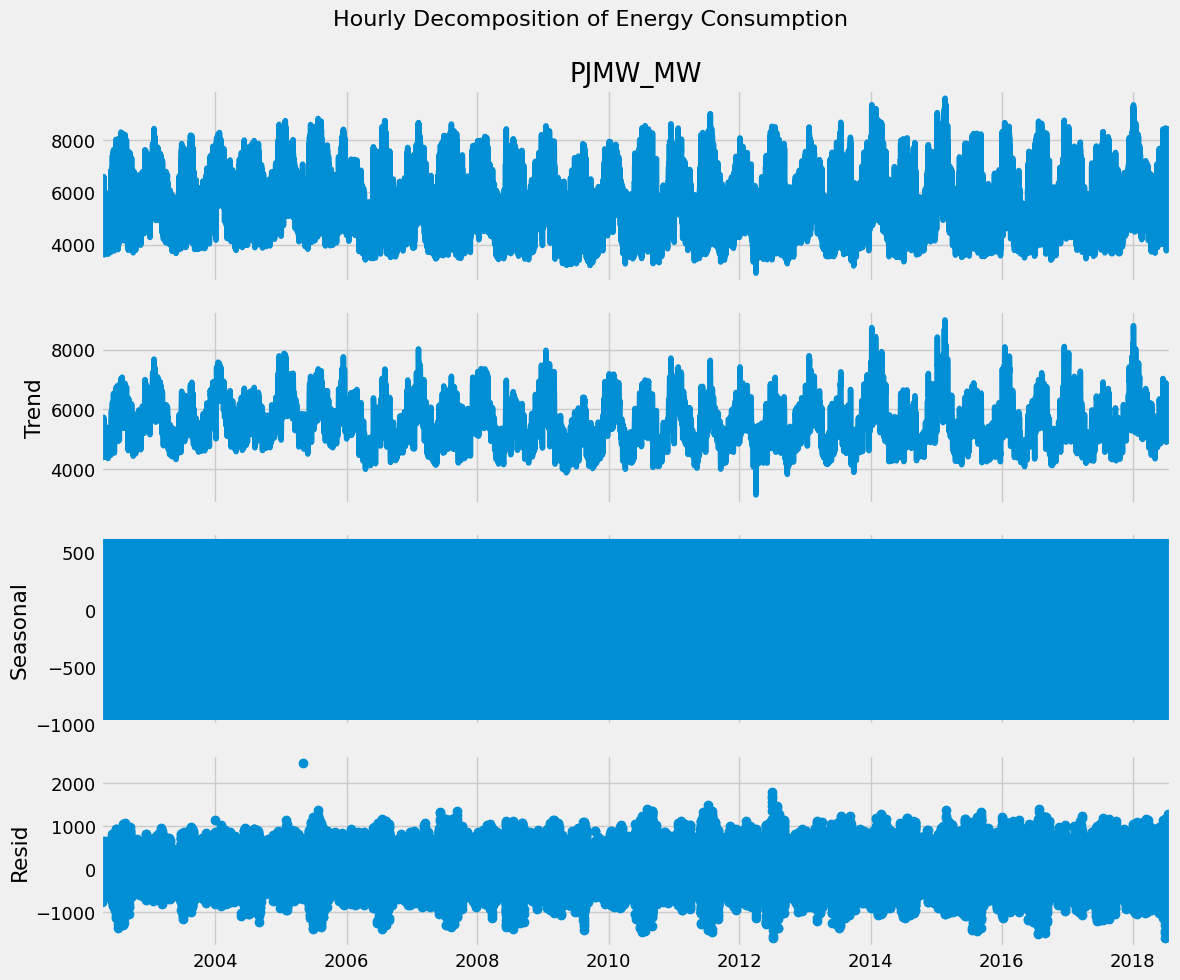

In [ ]:
hourly_decomposition = seasonal_decompose(df['PJMW_MW'], model='add', period=24)

plt.rc("figure", figsize=(12, 10))
plt.rc("font", size=13)

fig1 = hourly_decomposition.plot()
fig1.suptitle("Hourly Decomposition of Energy Consumption", fontsize=16)
fig1.tight_layout()
fig1.subplots_adjust(top=0.9)

plt.show()

And again wee see that we have some hourly seasonality, but also we have another type seasonalities, which can not be handeled by calssical models.

## Monthly smoothed data

In [ ]:
df_month = pd.DataFrame(df.resample('ME')['PJMW_MW'].mean().rename('M_AVG_PJMW_MW'))

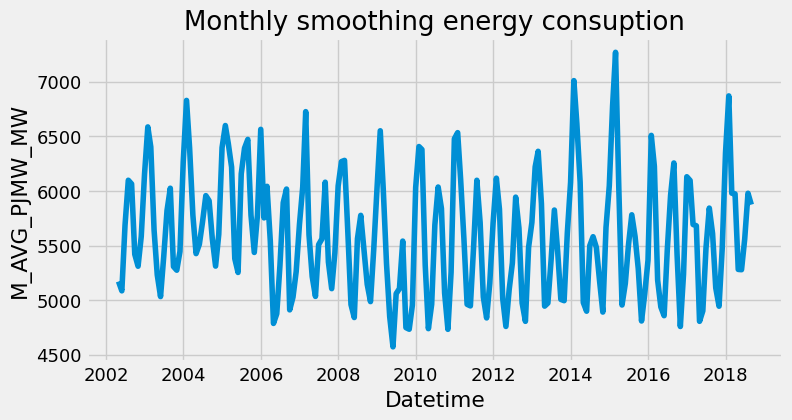

In [ ]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_month, x=df_month.index, y='M_AVG_PJMW_MW')
plt.title('Monthly smoothing energy consuption')

plt.show()

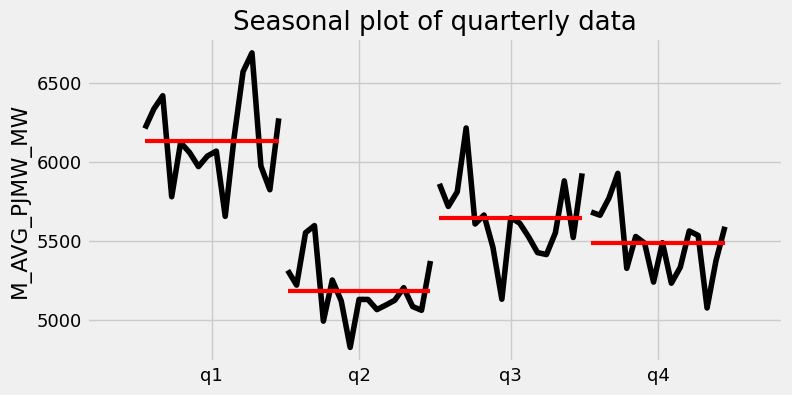

In [ ]:
fig = quarter_plot(df_month['M_AVG_PJMW_MW'].resample('QE').mean(), ylabel='M_AVG_PJMW_MW')
fig.set_size_inches(8, 4)
plt.title('Seasonal plot of quarterly data')

plt.show()

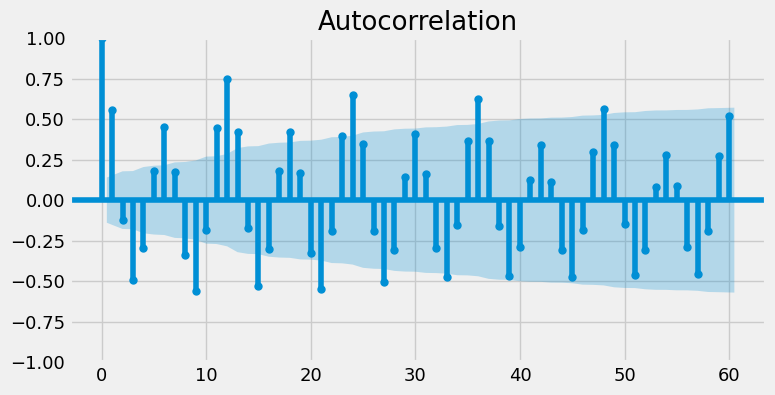

In [ ]:
fig = plot_acf(df_month['M_AVG_PJMW_MW'], lags=60)
fig.set_size_inches(8, 4)
plt.show()

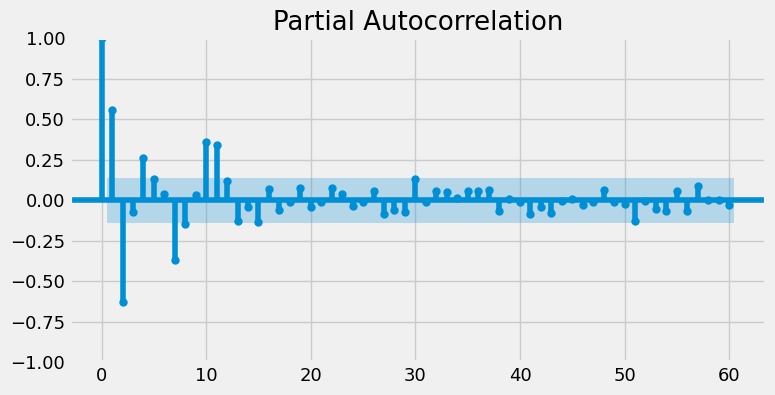

In [ ]:
fig = plot_pacf(df_month['M_AVG_PJMW_MW'], lags=60)
fig.set_size_inches(8, 4)
plt.show()

As displayed above the partial autocorrelation shows only the direct relationship between a timstep and its lag. The indirect relations are less significant and fall closer to zero.

When deciding on a regression model, the timeseries will need to undergo a transformation known as differencing to remove any seasonality or trend. This will make the data stationary (no trend or seasonality) and better suited for modeling.

In [ ]:
check_stationarity(df_month['M_AVG_PJMW_MW'])

ADF Statistic: -2.894377
p-value: 0.046006
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Stationary


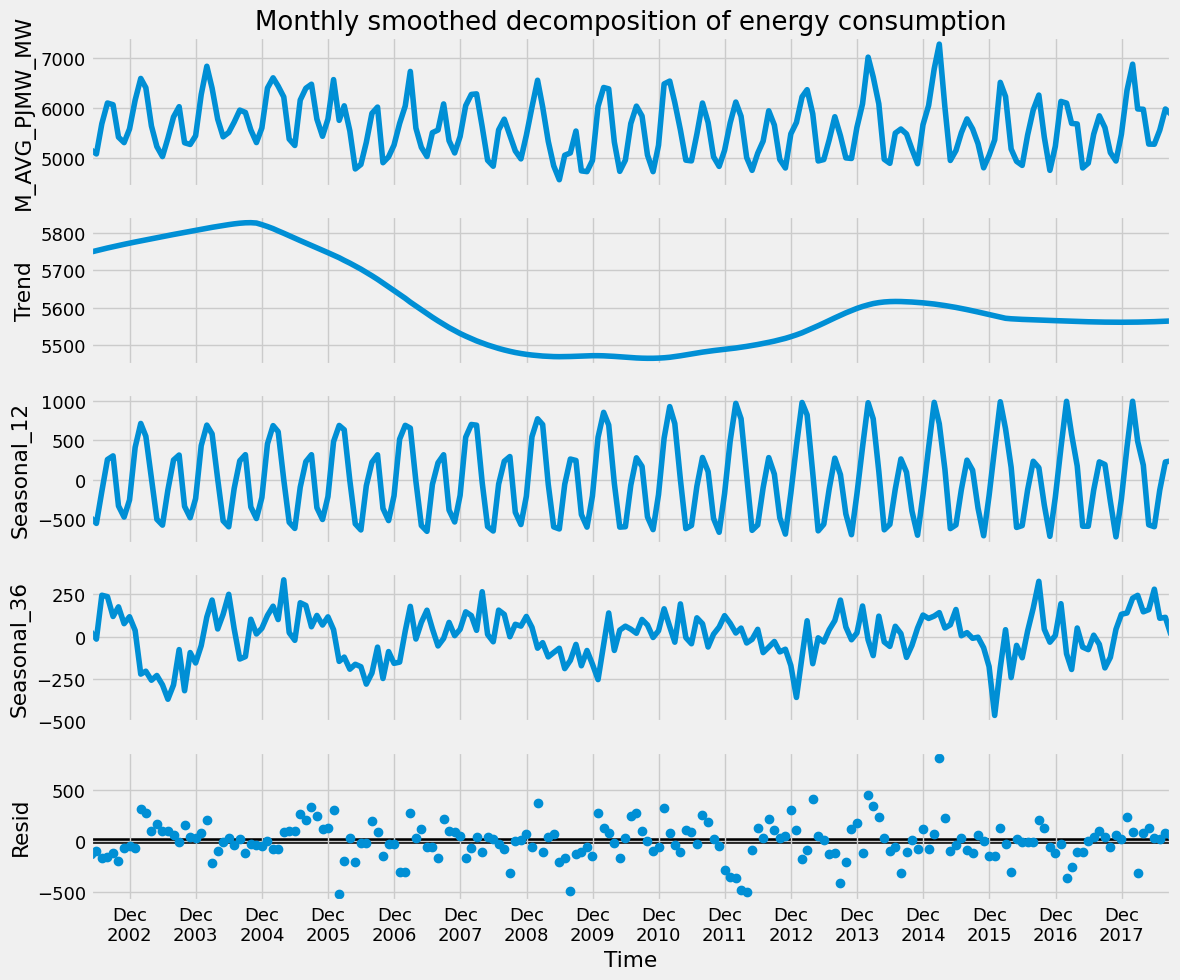

In [ ]:
res = MSTL(df_month['M_AVG_PJMW_MW'], periods=(12, 12*3)).fit()

plt.rc("figure", figsize=(12, 10))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2002-04-30", freq="MS", periods=12))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")

for ax in axs[:-1]:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

axs[0].set_ylabel("M_AVG_PJMW_MW")
axs[0].set_title("Monthly smoothed decomposition of energy consumption")
ax_last.set_xlabel("Time")

plt.tight_layout()

As we can observe from the MSTL decomposition plot, we have two types of seasonality: monthly and quarterly. Additionally, the smoothed trend does not show a strong directional increase or decrease. As a result, we are ready for modeling.

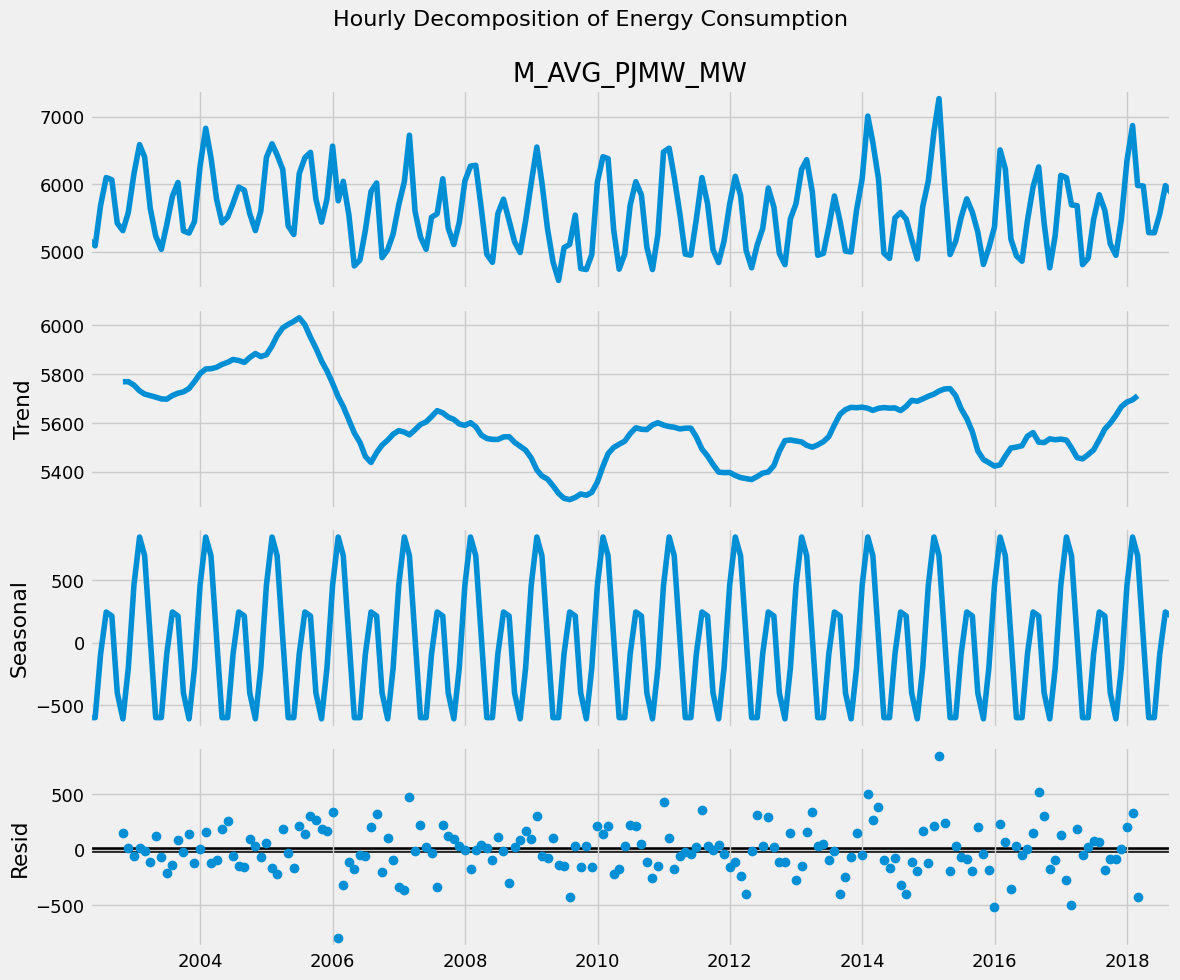

In [ ]:
decomposition = seasonal_decompose(df_month['M_AVG_PJMW_MW'], model='add', period=12)

plt.rc("figure", figsize=(12, 10))
plt.rc("font", size=13)

fig = decomposition.plot()
fig.suptitle("Hourly Decomposition of Energy Consumption", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.show()

# Modeling

# Dataset spliting

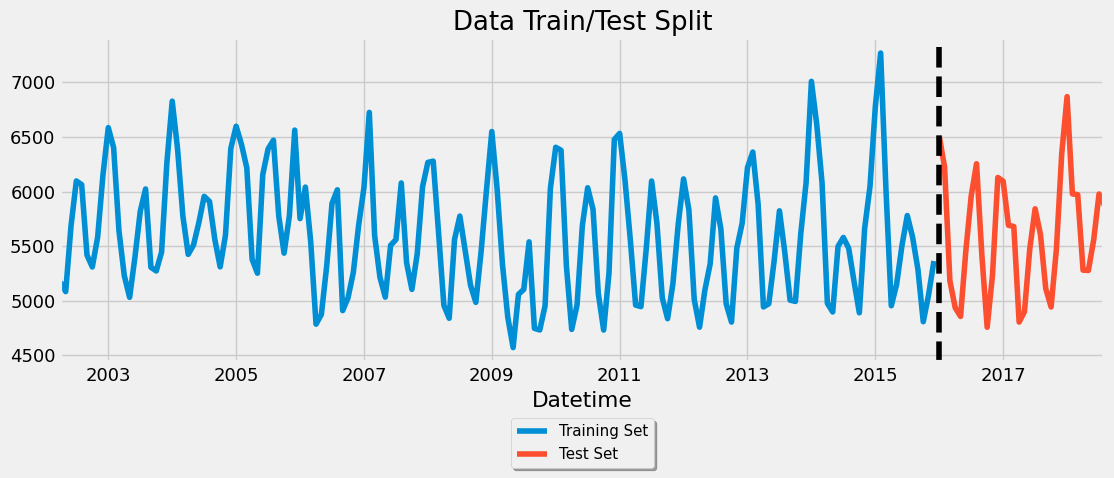

In [ ]:
train = df_month.loc[df_month.index < '2016-01-01']['M_AVG_PJMW_MW']  # train dataset
test = df_month.loc[df_month.index >= '2016-01-01']['M_AVG_PJMW_MW']  # validation dataset

fig, ax = plt.subplots(figsize=(12, 4))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2016-01-01', color='black', ls='--')
plt.legend(
    ['Training Set', 'Test Set'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)

plt.show()

In time series forecasting, the train/test split is a crucial step. Unlike standard machine learning data where shuffling is common, we cannot randomly split time series data. Instead, we must preserve the temporal order, training on earlier consecutive data points to predict subsequent consecutive points and capture historical patterns.

## ARIMA models

In time series forecasting, we can employ simple methods like the mean forecast, which uses the average of the training data as the prediction, or the naive approach, where all future forecasts are set to the last observed value. However, we will focus on more complex models such as ARIMA, Exponential Smoothing, and TBATS.

### Classic ARIMA

Therefore, when using the ARIMA model, we can apply different approaches such as implementing auto ARIMA or using our previous ACF and PACF analysis to manually set the necessary parameters. I will try implementing both methods and observe the differences.

In [ ]:
# manually parameters set
# p (AR) - PACF
# d - differencing
# q (MA) - ACF
m_arima_model = ARIMA(train, order=(12, 0, 12))
m_arima_fited = m_arima_model.fit()
print(m_arima_fited.summary())

                               SARIMAX Results                                
Dep. Variable:          M_AVG_PJMW_MW   No. Observations:                  165
Model:               ARIMA(12, 0, 12)   Log Likelihood               -1133.611
Date:                Thu, 15 May 2025   AIC                           2319.221
Time:                        08:33:59   BIC                           2399.976
Sample:                    04-30-2002   HQIC                          2352.002
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5603.1145     89.396     62.677      0.000    5427.901    5778.328
ar.L1         -0.1990      0.315     -0.632      0.528      -0.816       0.418
ar.L2          0.1700      0.224      0.757      0.4

In [ ]:
manual_arima_forecast = m_arima_fited.get_forecast(steps=len(test))
mean_forecast = manual_arima_forecast.predicted_mean
conf_int = manual_arima_forecast.conf_int(alpha=0.05)

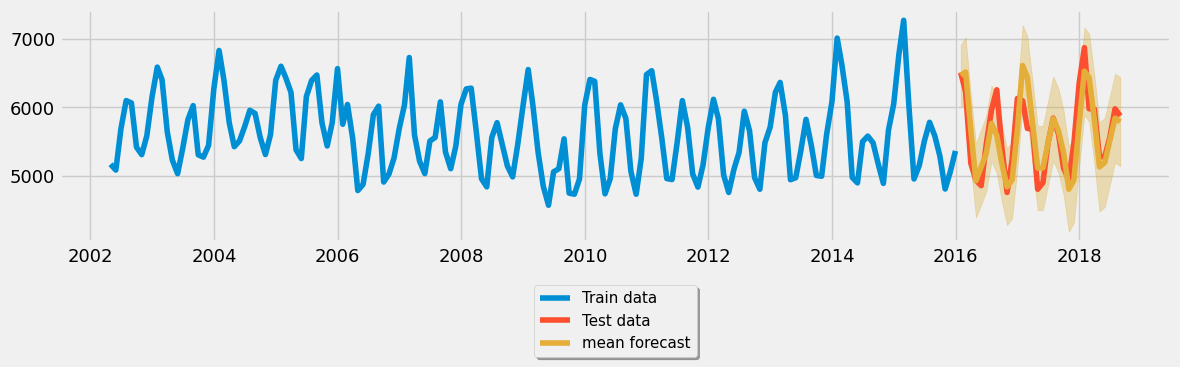

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(train, label='Train data')
plt.plot(test, label='Test data')
plt.plot(mean_forecast, label='mean forecast')

plt.fill_between(mean_forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='goldenrod', alpha=0.3)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.tight_layout()
plt.show()

In [ ]:
# also let's write error metrics function
def error_evaluation(test_data, prediction):
  mae = mean_absolute_error(test_data, prediction)
  print(f'MAE: {mae:.2f}')
  mse = mean_squared_error(test_data, prediction)
  print(f'MSE: {mse:.2f}')
  rmse = root_mean_squared_error(test_data, prediction)
  print(f'RMSE: {rmse:.2f}')
  mape = mean_absolute_percentage_error(test_data, prediction)
  print(f'MAPE: {100*mape:.2f}%')

In [ ]:
error_evaluation(test, mean_forecast)

MAE: 250.51
MSE: 103718.88
RMSE: 322.05
MAPE: 4.41%


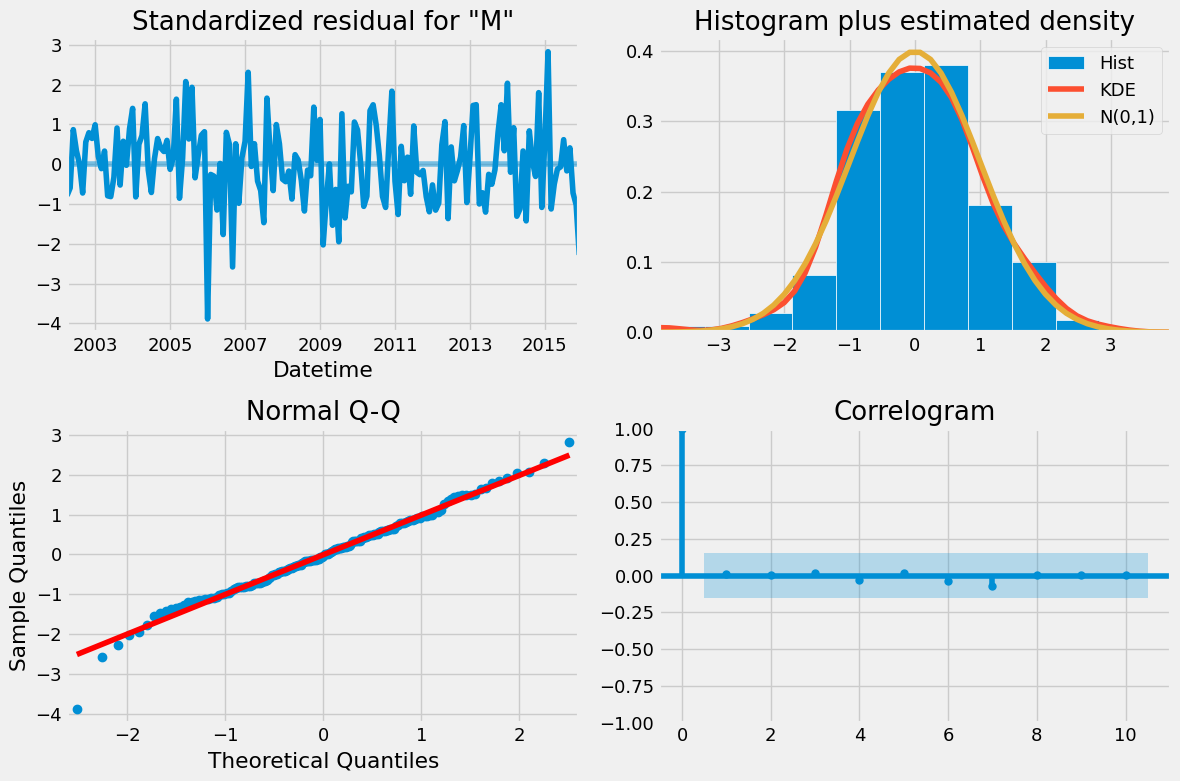

In [ ]:
# Residual Plots
m_arima_fited.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

So we obviously get pretty solid forecast from simple ARIMA model where we are manually set parametrs.

In [ ]:
# than let's implement simple auto-arima
a_arima_model = pm.auto_arima(y=train, seasonal=False)

In [ ]:
pd.DataFrame(a_arima_model.params()).T

,intercept,ar.L1,ar.L2,ar.L3,ar.L4,ar.L5,ma.L1,ma.L2,ma.L3,ma.L4,ma.L5,sigma2
0,2483.380967,1.647997,-0.879075,-0.977869,1.620522,-0.854284,-1.133191,0.506724,0.945667,-1.013055,0.513252,86179.700235


In [ ]:
# see that auto arima picks next parametrs: p=5, d=0, q=5
# and in overall we get higher AIC, but less BIC
print(f'AIC: {a_arima_model.aic():.2f}')
print(f'BIC: {a_arima_model.bic():.2f}')

AIC: 2334.67
BIC: 2371.94


In [ ]:
a_arima_predictions = a_arima_model.predict(n_periods=len(test))
error_evaluation(test, a_arima_predictions)

MAE: 266.62
MSE: 99812.07
RMSE: 315.93
MAPE: 4.71%


and also we get a little bigger errors than in first arima model.

### SARIMA and SARIMAX

Here, we can use a modification of the ARIMA model called SARIMA, which allows us to incorporate seasonality. Furthermore, SARIMAX enables us to also include exogenous variables.

In [ ]:
a_sarima_model = pm.auto_arima(train, seasonal=True, m=3)
print(f'AIC: {a_sarima_model.aic():.2f}')
print(f'BIC: {a_sarima_model.bic():.2f}')

AIC: 2363.54
BIC: 2391.50


In [ ]:
sarima_prediction = a_sarima_model.predict(n_periods=len(test))
error_evaluation(test, sarima_prediction)

MAE: 262.65
MSE: 99281.36
RMSE: 315.09
MAPE: 4.60%


We achieved better (lower) errors, but the resulting model is more complex, as indicated by the AIC and BIC parameters. Additionally, we observed that initially, a manually configured complex ARIMA model with larger p and q values yielded more accurate results.

## Exponentila Smoothing

The basic idea behind simple exponential smoothing is to assign greater weight to more recent observations compared to those from the distant past. Double exponential smoothing extends this by incorporating a smoothed trend. And triple exponential smoothing, also known as the Holt-Winters method, includes three components: level, trend, and seasonality. So for this data we Implement

In [ ]:
exp_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
exp_smoothing_pred = exp_model.forecast(len(test))

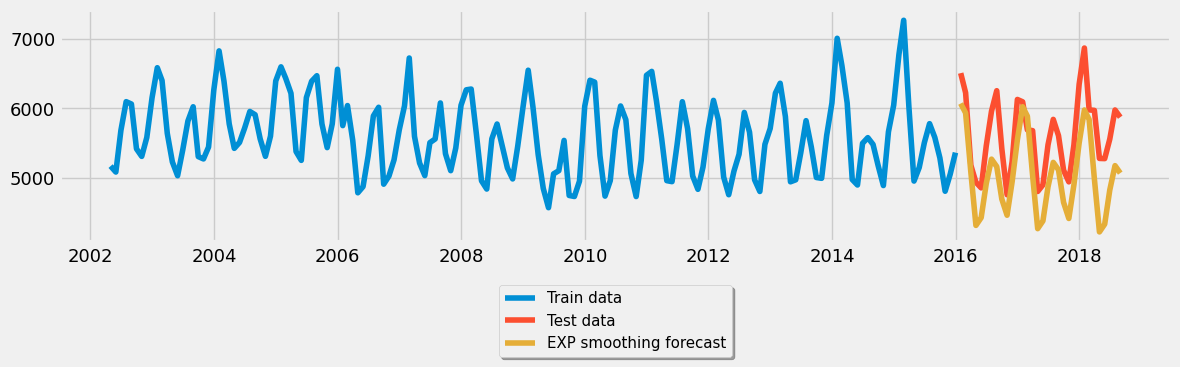

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(train, label='Train data')
plt.plot(test, label='Test data')
plt.plot(exp_smoothing_pred, label='EXP smoothing forecast')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.tight_layout()
plt.show()

In [ ]:
error_evaluation(test, exp_smoothing_pred)

MAE: 579.03
MSE: 406309.29
RMSE: 637.42
MAPE: 10.30%


## Linear Regression

Also we can implement to time series problem classic machine learning regression models like LinearRegression. The main advantage of machine learning algorithms is their ability to incorporate all available numerical data, which can be very powerful. However, this also means that the model's output is highly dependent on the quality of the input data, leading to the risk of a 'garbage in, garbage out' scenario.

In [ ]:
lr_train = pd.DataFrame(train.copy())
lr_train['trend'] = range(1, len(train)+1)
lr_train['month'] = lr_train.index.month
lr_train['quarter'] = lr_train.index.quarter
x_train, y_train = lr_train.drop('M_AVG_PJMW_MW', axis=1), lr_train['M_AVG_PJMW_MW']

lr_test = pd.DataFrame(test.copy())
lr_test['trend'] = range(len(train)+1, len(train)+len(test)+1)
lr_test['month'] = lr_test.index.month
lr_test['quarter'] = lr_test.index.quarter
x_test, y_test = lr_test.drop('M_AVG_PJMW_MW', axis=1 ), lr_test['M_AVG_PJMW_MW']

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)

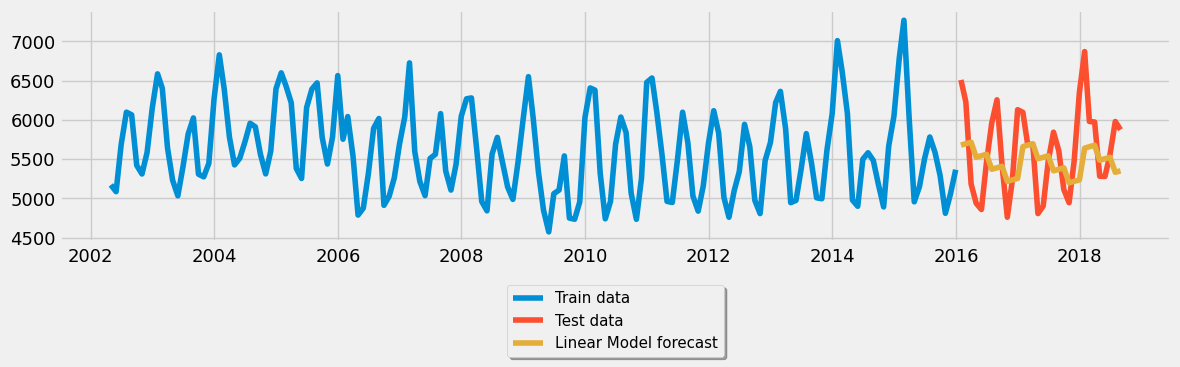

In [ ]:
lr_predict_df = pd.DataFrame(index=test.index, data=lr_predict)
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(train, label='Train data')
plt.plot(test, label='Test data')
plt.plot(lr_predict_df, label='Linear Model forecast')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.tight_layout()
plt.show()

In [ ]:
error_evaluation(y_test, lr_predict)

MAE: 438.83
MSE: 295822.30
RMSE: 543.90
MAPE: 7.68%


## BATS and TBATS

BATS (Box-Cox transformation, ARMA errors, Trend, and Seasonal components) is an extension of exponential smoothing methods that combines a Box-Cox transformation to handle non-linear data and uses an ARMA model to capture autocorrelation in the residuals. TBATS represents each seasonal period as a trigonometric representation based on Fourier series. This allows the model to fit large seasonal periods and non-integer seasonal periods.

Overall, BATS and TBATS are very powerful approaches that accommodate multiple seasonalities and data with non-constant variance.

In [ ]:
estimator = TBATS(seasonal_periods=[4, 12],
                  # use_arma_errors=False,  # shall try only models without ARMA
                  # use_box_cox=False  # will not use Box-Cox
                  )

tbats_fitted_model = estimator.fit(train)
tbats_fitted_model.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: [ 4. 12.]\nSeasonal harmonics [1 2]\nARMA errors (p, q): (0, 0)\nSmoothing (Alpha): 0.519438\nTrend (Beta): -0.107018\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [ 2.05922393e-07  1.64920081e-07  1.22732447e-07 -6.74816675e-08]\nAR coefficients []\nMA coefficients []\nSeed vector [5904.61124642  -10.34006634   -7.61067107  -46.33821961   10.97947897\n -580.28501238 -336.29089101 -153.56163818]\n\nAIC 2668.429014'

In [ ]:
tbats_forecast = tbats_fitted_model.forecast(steps=len(test))

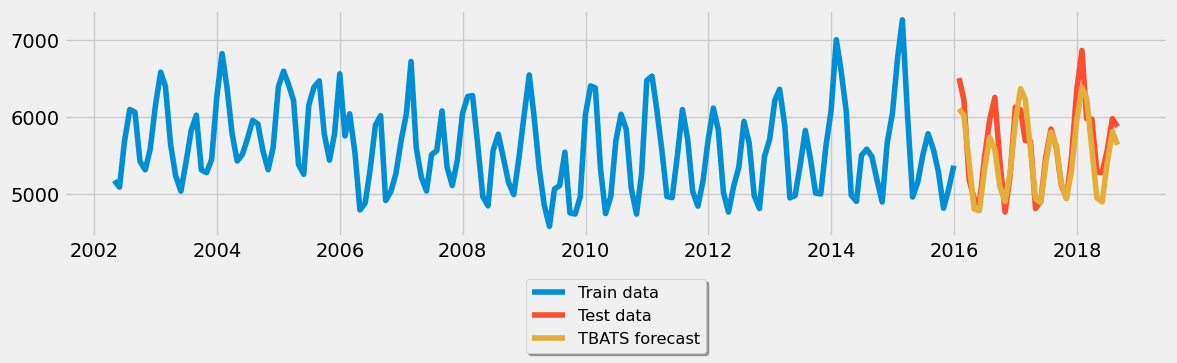

In [ ]:
tbats_forecast_df = pd.DataFrame(index=test.index, data=tbats_forecast)
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(train, label='Train data')
plt.plot(test, label='Test data')
plt.plot(tbats_forecast_df, label='TBATS forecast')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.tight_layout()
plt.show()

In [ ]:
error_evaluation(test, tbats_forecast)

MAE: 220.47
MSE: 74951.13
RMSE: 273.77
MAPE: 3.80%


While we achieved the best overall metrics with the TBATS model among the classical time series approaches, it's worth noting that the traditional ARIMA model performed reasonably well for this particular dataset.

# Back to initial dataset

As mentioned previously, classical time series models (with the exception of BATS and TBATS) struggle to handle complex time series data or data with multiple seasonality, as we have. Therefore, I will explore implementing more advanced models such as XGBoost, Prophet, or even LSTM.

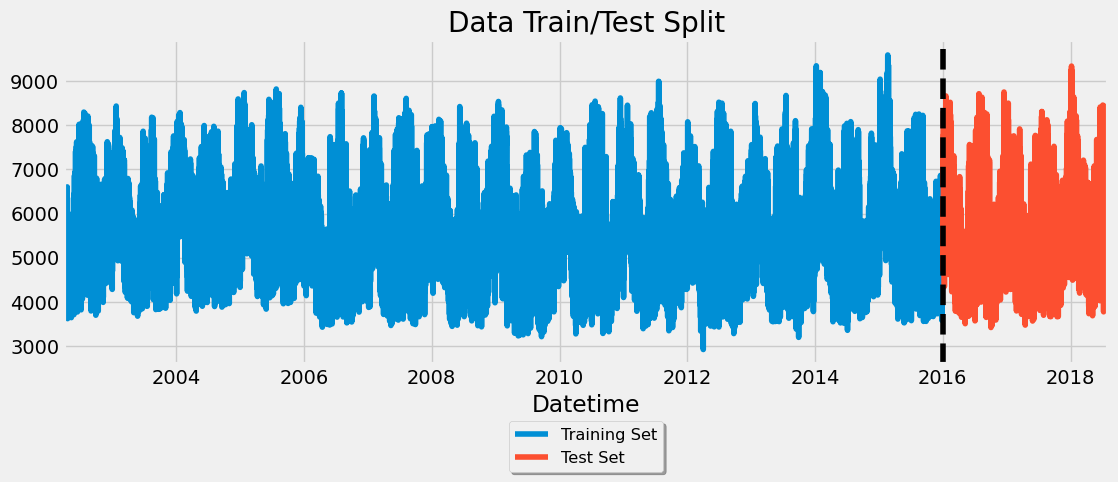

In [ ]:
ftrain = pd.DataFrame(df.loc[df.index < '2016-01-01']['PJMW_MW'])  # train dataset
ftest = pd.DataFrame(df.loc[df.index >= '2016-01-01']['PJMW_MW'])  # validation dataset

fig, ax = plt.subplots(figsize=(12, 4))
ftrain.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
ftest.plot(ax=ax, label='Test Set')
ax.axvline('2016-01-01', color='black', ls='--')
plt.legend(
    ['Training Set', 'Test Set'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)

plt.show()

## XGBoost

Given this hourly data, we can even incorporate holiday markers as features to potentially predict energy consumption more accurately.

In [ ]:
cal = calendar()
holidays = cal.holidays(start=df.index.min(),
                        end=df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})
xgb_holiday_df = holiday_df.copy()
xgb_holiday_df['ds'] = xgb_holiday_df['ds'].dt.strftime('%Y-%m-%d')

In [ ]:
def make_holidays_df(df, holiday_df):
  all_hourly_holiday_df = pd.DataFrame()
  for date in holiday_df['ds'].unique():
    if date in df.index:
        matches = df.loc[date]
        if not matches.empty:
            hourly_holiday_df = pd.DataFrame(index=matches.index, data=[1]*len(matches))
            all_hourly_holiday_df = pd.concat([all_hourly_holiday_df, hourly_holiday_df], axis=0)

  all_hourly_holiday_df = all_hourly_holiday_df.rename(columns={0:'isholiday'})

  return all_hourly_holiday_df

In [ ]:
# feature preprocessing for xgboost
ftrain = create_features(ftrain)
ftest = create_features(ftest)

train_holidays = make_holidays_df(ftrain, xgb_holiday_df)
ftrain = ftrain.merge(train_holidays, how='left', left_index=True, right_index=True)
ftrain['isholiday'] = np.where(pd.isna(ftrain['isholiday']), 0, 1)

test_holidays = make_holidays_df(ftest, xgb_holiday_df)
ftest = ftest.merge(test_holidays, how='left', left_index=True, right_index=True)
ftest['isholiday'] = np.where(pd.isna(ftest['isholiday']), 0, 1)

FEATURES = ['dayofyear', 'hour', 'n_dayofweek', 'quarter', 'month', 'year', 'isholiday']
TARGET = 'PJMW_MW'

X_train = ftrain[FEATURES]
y_train = ftrain[TARGET]

X_test = ftest[FEATURES]
y_test = ftest[TARGET]

In [ ]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                             n_estimators=400,
                             early_stopping_rounds=50,
                            #  objective='reg:linear',
                             max_depth=3,
                             learning_rate=0.01)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=40)

[0]	validation_0-rmse:5628.63034	validation_1-rmse:5641.18649
[40]	validation_0-rmse:3801.57055	validation_1-rmse:3796.48294
[80]	validation_0-rmse:2593.56126	validation_1-rmse:2586.73737
[120]	validation_0-rmse:1802.41973	validation_1-rmse:1810.07938
[160]	validation_0-rmse:1292.20288	validation_1-rmse:1316.95627
[200]	validation_0-rmse:977.99509	validation_1-rmse:1026.34439
[240]	validation_0-rmse:790.11607	validation_1-rmse:866.86065
[280]	validation_0-rmse:681.06268	validation_1-rmse:783.79776
[320]	validation_0-rmse:619.06362	validation_1-rmse:741.91617
[360]	validation_0-rmse:582.66960	validation_1-rmse:720.46821
[399]	validation_0-rmse:561.14385	validation_1-rmse:710.47431


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

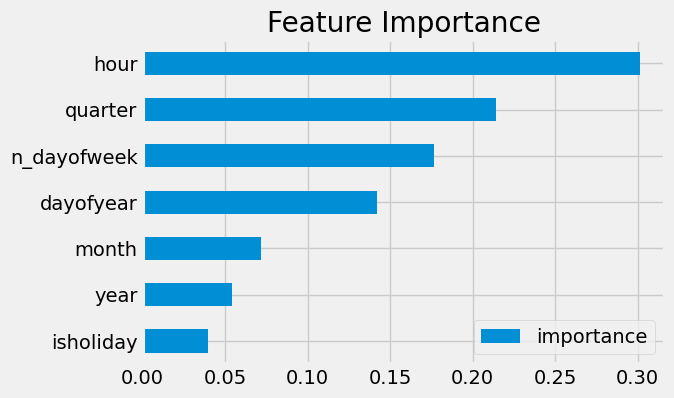

In [ ]:
# Feature importance - extremely useful thing
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(6, 4))
plt.title('Feature Importance')
plt.show()

See that hourly and quarterly seasonality are really strong.

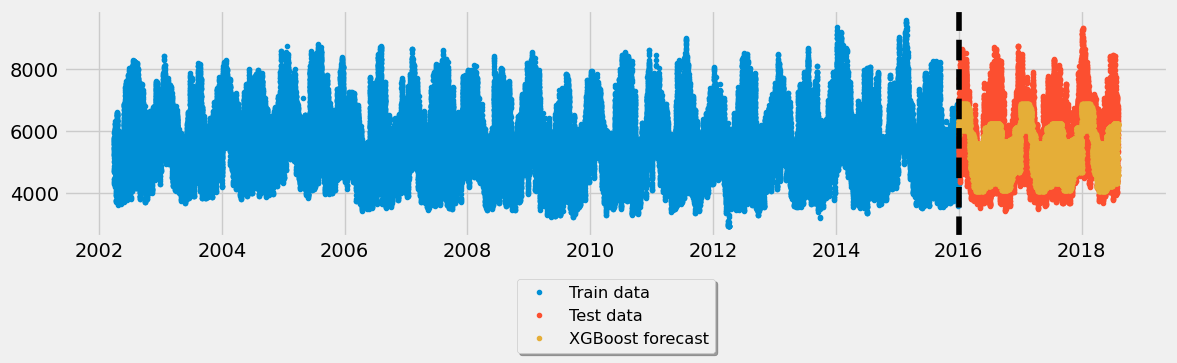

In [ ]:
ftest['xgb_predict'] = xgb_model.predict(X_test)

plt.figure(figsize=(12, 4))
plt.plot(ftrain['PJMW_MW'], label='Train data', marker='.', linestyle='')
plt.plot(ftest['PJMW_MW'], label='Test data', marker='.', linestyle='')
plt.plot(ftest['xgb_predict'], label='XGBoost forecast', marker='.', linestyle='')
plt.axvline(pd.to_datetime('2016-01-01'), color='black', ls='--')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.tight_layout()
plt.show()

In [ ]:
error_evaluation(ftest['PJMW_MW'], ftest['xgb_predict'])

MAE: 542.10
MSE: 504773.75
RMSE: 710.47
MAPE: 9.34%


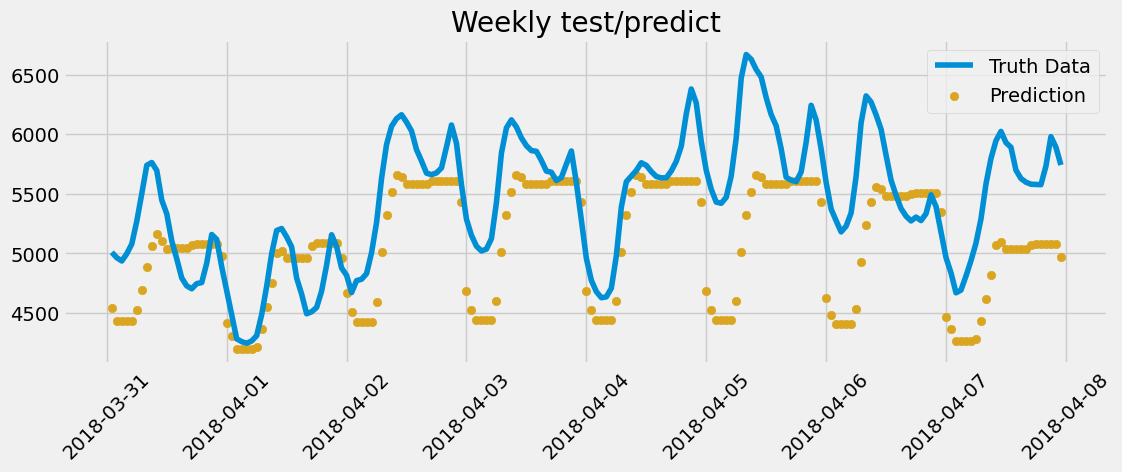

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ftest.loc[(ftest.index > '2018-03-31') & (ftest.index < '2018-04-08')]['PJMW_MW'])
plt.scatter(ftest.loc[(ftest.index > '2018-03-31') & (ftest.index < '2018-04-08')].index,
            ftest.loc[(ftest.index > '2018-03-31') & (ftest.index < '2018-04-08')]['xgb_predict'],
            color='goldenrod')
plt.xticks(rotation=45)

plt.title('Weekly test/predict')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Prophet

Prophet is an open-source complex tool released by Facebook's Data Science team that produces time series forecasting data based on an additive model where a non-linear trend fits with seasonality and holiday effects.

In [ ]:
ftrain = pd.DataFrame(df.loc[df.index < '2016-01-01']['PJMW_MW'])
ftest = pd.DataFrame(df.loc[df.index >= '2016-01-01']['PJMW_MW'])

prophet_train = ftrain.reset_index().rename(columns={'Datetime':'ds',
                                                     'PJMW_MW':'y'})
prophet_test = ftest.reset_index().rename(columns={'Datetime':'ds',
                                                   'PJMW_MW':'y'})

In [ ]:
%%time
prophet_model = Prophet(holidays=holiday_df)
prophet_model.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmppr7og1o_/vtdpi04w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppr7og1o_/s6v8k8dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12756', 'data', 'file=/tmp/tmppr7og1o_/vtdpi04w.json', 'init=/tmp/tmppr7og1o_/s6v8k8dy.json', 'output', 'file=/tmp/tmppr7og1o_/prophet_modeljpcean01/prophet_model-20250515132858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 16 s, sys: 843 ms, total: 16.8 s
Wall time: 3min


In [ ]:
prophet_prediction = prophet_model.predict(df=prophet_test)

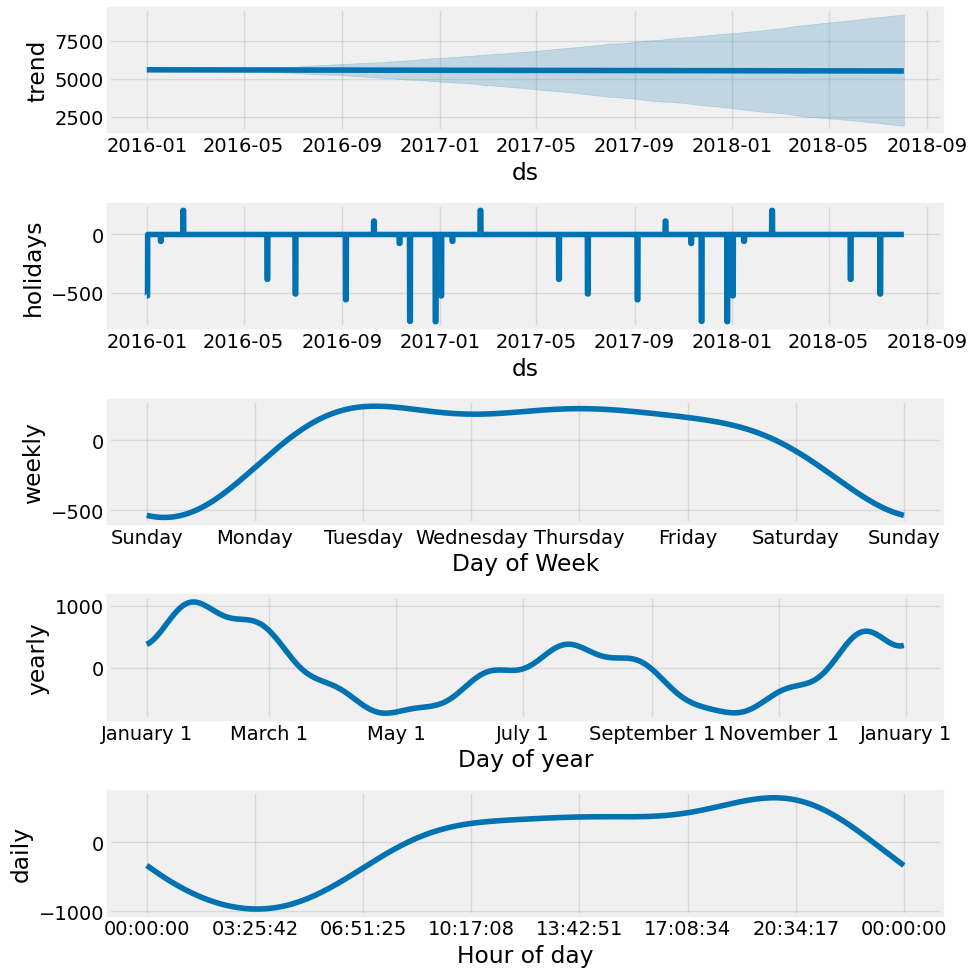

In [ ]:
fig = prophet_model.plot_components(prophet_prediction)
fig.set_size_inches(10, 10)
plt.tight_layout()
plt.show()

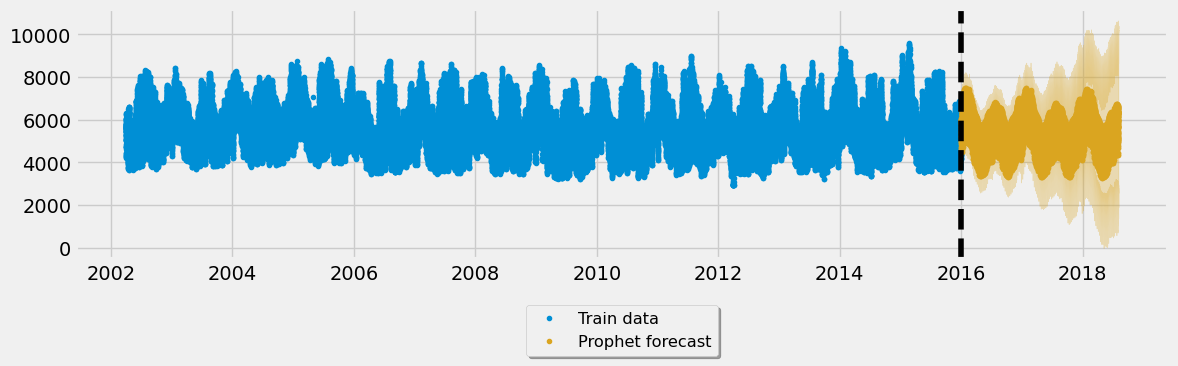

In [ ]:
temp_prophet_pred = prophet_prediction.set_index('ds')

plt.figure(figsize=(12, 4))
plt.plot(ftrain['PJMW_MW'], label='Train data', marker='.', linestyle='')
# plt.plot(ftest['PJMW_MW'], label='Test data', marker='.', linestyle='', alpha=0.25)
plt.plot(temp_prophet_pred['yhat'], label='Prophet forecast', marker='.', linestyle='', color='goldenrod')
plt.axvline(pd.to_datetime('2016-01-01'), color='black', ls='--')

plt.fill_between(temp_prophet_pred.index,
                 temp_prophet_pred['yhat_lower'],
                 temp_prophet_pred['yhat_upper'], color='goldenrod', alpha=0.3)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    fontsize='small'
)
plt.tight_layout()
plt.show()

In [ ]:
error_evaluation(prophet_test['y'], temp_prophet_pred['yhat'])

MAE: 534.82
MSE: 498944.78
RMSE: 706.36
MAPE: 9.24%


We observe that the Prophet model performs slightly better than the previous XGBoost model on this comprehensive dataset.

## LSTM

In [ ]:
# ...

# Cross-validation for Time Series

In [ ]:
# split time series data five times with 1 year of test size data
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

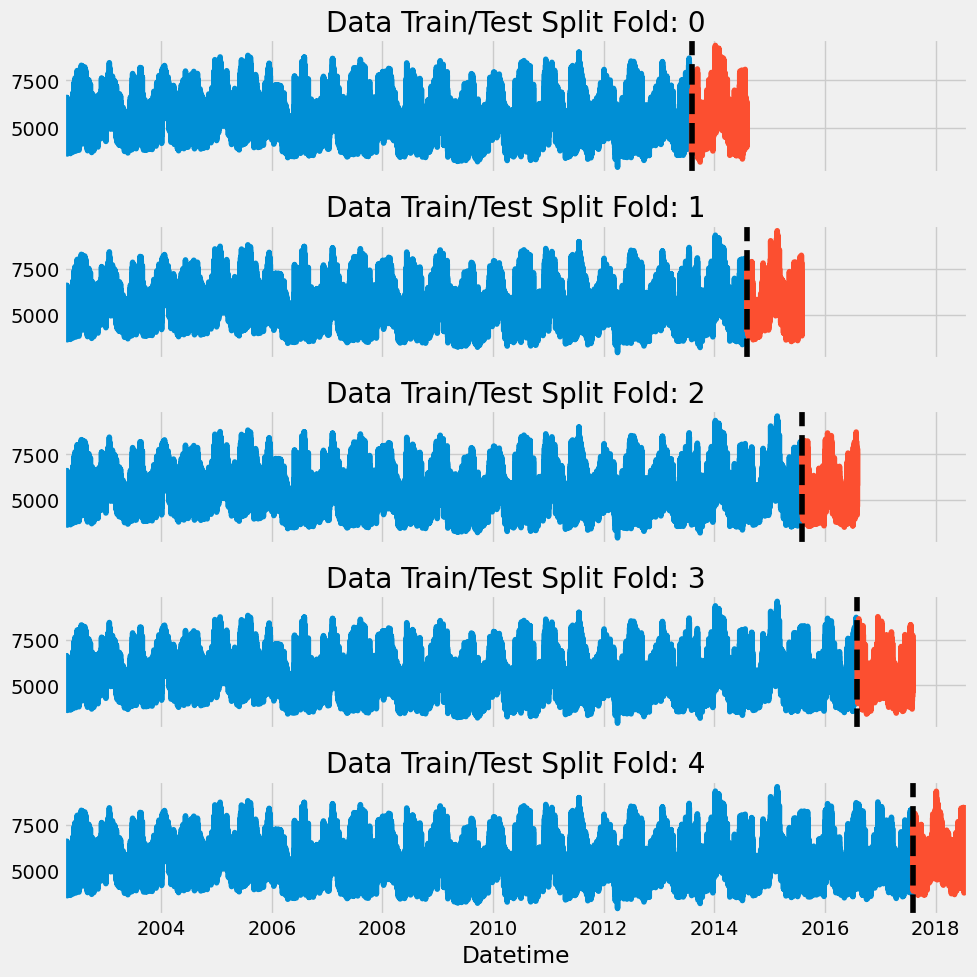

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]
  train['PJMW_MW'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Test Split Fold: {fold}')
  test['PJMW_MW'].plot(ax=axs[fold],
                        label='Test Set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1

plt.tight_layout()
plt.show()

In [ ]:
# making some laggs with one, two and three years

def add_lags(df):
  target_map = df['PJMW_MW'].to_dict()
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
  return df

df = add_lags(df)

In [ ]:
# for the subsequent cross-validation modeling, I chose not to include holidays as a feature,
# based on the previous observation that it did not appear to be a highly significant predictor.

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]

  train = create_features(train)
  test = create_features(test)

  FEATURES = ['dayofyear', 'hour', 'n_dayofweek', 'quarter', 'month','year',
              'lag1','lag2','lag3']
  TARGET = 'PJMW_MW'

  X_train = train[FEATURES]
  y_train = train[TARGET]

  X_test = test[FEATURES]
  y_test = test[TARGET]

  xgb_model_cv = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                         n_estimators=400,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)
  xgb_model_cv.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

  y_pred = xgb_model_cv.predict(X_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)

[0]	validation_0-rmse:5625.46952	validation_1-rmse:5689.19283
[100]	validation_0-rmse:2135.27609	validation_1-rmse:2287.09354
[200]	validation_0-rmse:940.60179	validation_1-rmse:1120.27301
[300]	validation_0-rmse:605.65050	validation_1-rmse:769.88556
[399]	validation_0-rmse:530.16241	validation_1-rmse:672.97308
[0]	validation_0-rmse:5630.48015	validation_1-rmse:5764.81478
[100]	validation_0-rmse:2138.38303	validation_1-rmse:2345.80894
[200]	validation_0-rmse:945.87487	validation_1-rmse:1161.14292
[300]	validation_0-rmse:613.66590	validation_1-rmse:759.96613
[399]	validation_0-rmse:539.73174	validation_1-rmse:645.83355
[0]	validation_0-rmse:5640.31226	validation_1-rmse:5470.48015
[100]	validation_0-rmse:2143.67186	validation_1-rmse:1998.58880
[200]	validation_0-rmse:950.13982	validation_1-rmse:844.85135
[300]	validation_0-rmse:618.45528	validation_1-rmse:621.71095
[365]	validation_0-rmse:559.83395	validation_1-rmse:628.59840
[0]	validation_0-rmse:5628.67304	validation_1-rmse:5556.40734


In [ ]:
print(f'Mean score across the folds {np.mean(scores):0.4f}')
print(f'All fold scores:{scores}')

Mean score across the folds 666.1663
All fold scores:[672.9730770553231, 645.8335498945895, 620.1370240421556, 692.2767836312499, 699.6111170148621]


## Using model for prediction unseen data

In [ ]:
# making training again to predict unseen data
FEATURES = ['dayofyear', 'hour', 'n_dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJMW_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

xgb_modelf = xgb.XGBRegressor(base_score=0.5,
                              booster='gbtree',
                              n_estimators=400,
                              objective='reg:linear',
                              max_depth=3,
                              learning_rate=0.01)

xgb_modelf.fit(X_all, y_all,
               eval_set=[(X_all, y_all)],
               verbose=100)

[0]	validation_0-rmse:5630.59448
[100]	validation_0-rmse:2143.30443
[200]	validation_0-rmse:960.13663
[300]	validation_0-rmse:638.14878
[399]	validation_0-rmse:566.86591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
print(f'Last noted data: {df.index.max()}')
interval = df.index.max() + pd.Timedelta('364 days')
print(f'Last date for predicting unseen future: {interval}')

Last noted data: 2018-08-03 00:00:00
Last date for predicting unseen future: 2019-08-02 00:00:00


In [ ]:
future = pd.date_range(df.index.max(),interval, freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

clean_df = pd.DataFrame(df['PJMW_MW'].copy())
clean_df['isFuture'] = False
new_df = pd.concat([clean_df, future_df])
new_df = create_features(new_df)
new_df = add_lags(new_df)

In [ ]:
future_data = new_df[new_df['isFuture']==True].dropna(subset='lag1')
future_predictions = xgb_modelf.predict(future_data[FEATURES])

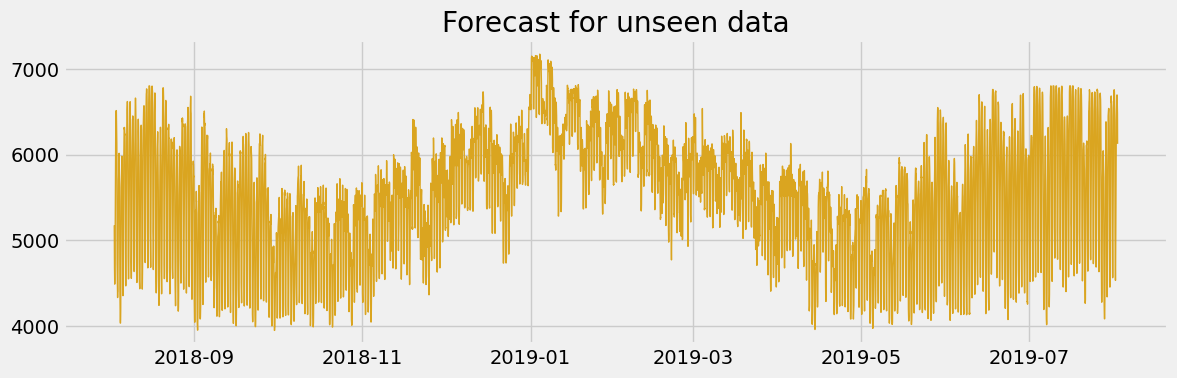

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(future_data.index, future_predictions,
         label='XGB forecast',
         color='goldenrod', lw=1)

plt.title('Forecast for unseen data')
plt.tight_layout()
plt.show()

DONE

https://www.kaggle.com/code/davidanimaddo/energy-timeseries-advanced-data-visualization#7.-Timeseries-Differencing

https://github.com/KishManani/MSTL/blob/main/mstl_decomposition.ipynb

https://neptune.ai/blog/anomaly-detection-in-time-series

https://habr.com/ru/companies/ods/articles/327242/

https://stackoverflow.com/questions/62634182/are-there-any-rules-when-it-comes-to-determining-the-order-and-the-seasonal-orde

https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting#15.-SARIMAX-model-with-exogeneous-variables-

https://nixtlaverse.nixtla.io/statsforecast/docs/models/multipleseasonaltrend.html

https://www.kaggle.com/code/pythonafroz/a-guide-to-time-series-analysis-part-02

https://medium.com/@alex.eslava96/outlier-detection-techniques-for-time-series-9868db2875c2

https://medium.com/@james.ralph8555/end-to-end-time-series-forecasting-project-with-tbats-and-pandas-in-python-4c56a2771023

https://medium.com/data-science/the-ultimate-guide-to-finding-outliers-in-your-time-series-data-part-2-674c25837f29

https://freedium.cfd/https://medium.com/the-forecaster/how-to-forecast-time-series-with-multiple-seasonalities-23c77152347e

https://freedium.cfd/https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9